# Linear Sequential Estimation

In [45]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import statsmodels.api as sm

np.random.seed(1)

In [46]:
# Import functions directly from github
# Important: note that we use raw.githubusercontent.com, not github.com

import requests
url = 'https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Utility/plot_utility.py'
r = requests.get(url)

# Store the file to the colab working directory
with open('plot_utility.py', 'w') as f:
    f.write(r.text)

# import the function we want from that file
from plot_utility import plot_tme

# Generate sample time series data

In [47]:
t = np.linspace(0, 6, 500)
x = np.array([[1, 1, 2, -0.4e-4]]).T
H = np.vstack([t, np.sin(t), np.cos(2*t), np.exp(t)]).T
y = H@x

# Add some normal (gaussian) noise

In [48]:
# Example for Gaussian (normal) random variable

noise_mean = 0
noise_std = 0.5

v = np.column_stack(np.random.normal(noise_mean, noise_std, len(y))).T

In [49]:
y_tilde = y+v

# Plotting

<Axes: xlabel='Time', ylabel='y'>

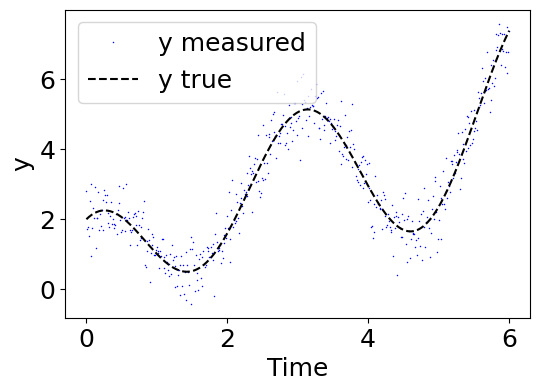

In [50]:
plot_tme(t, y, y_tilde)

# Candidate models

In [51]:
model_1_H = np.vstack([t, np.sin(t), np.cos(2*t)]).T

# Exercise

Implement Linear Sequential Estimation, and plot the three parameters of $x$ over time

$\hat{x_{k+1}} = \hat{x}_k + K_{k+1} (̃\tilde{y_{k+1}}) -H_{k+1} \cdot ̂\hat{x}_k$

In [52]:
I = np.array([[1,0,0],
              [0,1,0],
              [0,0,1]])
W = 1


# Task
Implement linear sequential estimation (Kalman filter) to estimate the parameters of a linear system given noisy measurements.

In [61]:
def update(x_k, P_k, H_k_plus_1, y_k_plus_1, W):
  S = H_k_plus_1 @ P_k @ H_k_plus_1.T + W[0,0]
  K = P_k @ H_k_plus_1.T @ np.linalg.inv(S)
  x_k_plus_1 = x_k + K @ (y_k_plus_1 - H_k_plus_1 @ x_k)
  P_k_plus_1 = P_k - K @ H_k_plus_1 @ P_k
  return x_k_plus_1, P_k_plus_1

In [62]:
W = np.eye(3)
x_estimate = [np.ones((3, 1))]
P_estimate = [np.eye(3) *10]

for i in range(len(y_tilde)):
  y_k_plus_1 = y_tilde[i].reshape(-1,1)
  H_k_plus_1 = np.array(model_1_H[i]).reshape(1,-1) # Reshape to (1, 3)
  P_k = P_estimate[-1]
  x_k = x_estimate[-1]
  x_k_plus_1, P_k_plus_1 = update(x_k, P_k, H_k_plus_1, y_k_plus_1, W)
  x_estimate.append(x_k_plus_1)
  P_estimate.append(P_k_plus_1)

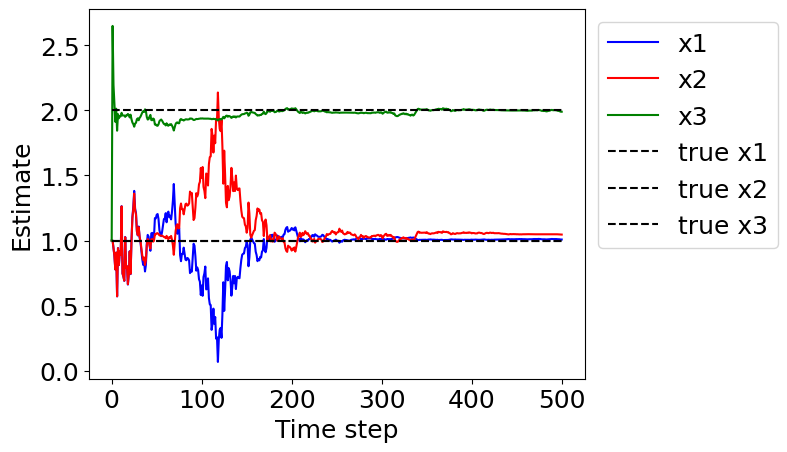

In [63]:
x_estimate = np.array(x_estimate)
plt.plot(x_estimate[:, 0], label='x1', color='b')
plt.plot(x_estimate[:, 1], label='x2', color='r')
plt.plot(x_estimate[:, 2], label='x3', color='g')
# plot true values
plt.hlines(1, 0, len(x_estimate), colors='black', linestyles='dashed', label='true x1')
plt.hlines(1, 0, len(x_estimate), colors='black', linestyles='dashed', label='true x2')
plt.hlines(2, 0, len(x_estimate), colors='black', linestyles='dashed', label='true x3')
plt.xlabel('Time step')
plt.ylabel('Estimate')
# legend outside of plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()